## Importing the libraries

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
RANDOM_STATE = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the DataSet

In [46]:
Insurance = pd.read_csv("Insurance.csv")
Insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Charges refers to the amount of money spent by the person for a calender year. it's also our target

## Exploratory Data Analysis

In [47]:
Insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [48]:
Insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the our numerical data, we see that the mean and the median are significantly far off from each other in our target, unlike that of Age, Bmi, and Children. This, however, indicates that there is a form of skewness with our target, Charges. 

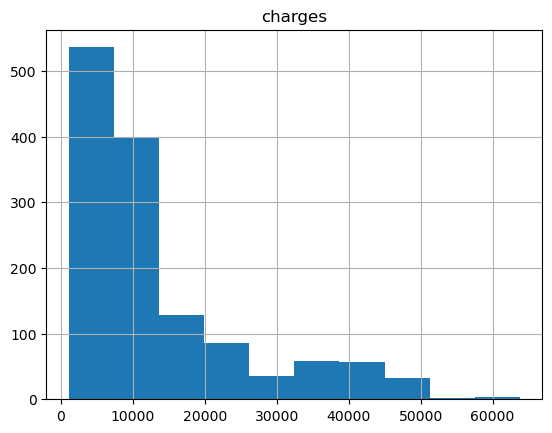

In [49]:
Insurance.hist('charges')
plt.show()

The histogram reveals the skewness. But what we want is a normal distribution for more accuracy in a linear fashion. We can use a base 2 log to transform the column. 

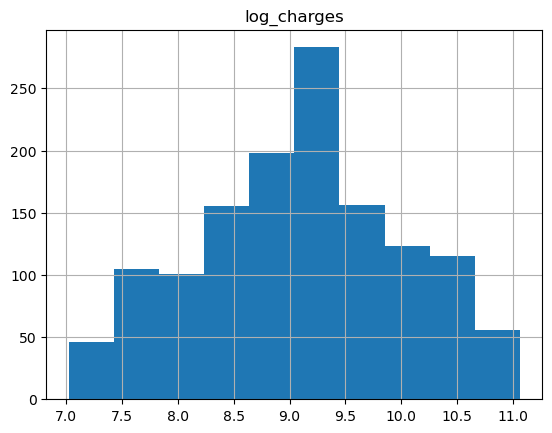

In [50]:
Insurance["log_charges"] = np.log(Insurance["charges"])

Insurance.hist('log_charges')
plt.show()

We can see that it is more normally distributed now.

Checking to find correlation between our independent variables and our depended variable, `charges`

In [51]:
correlations = Insurance.select_dtypes(['number']).corr()
correlations
print(correlations.shape)

(5, 5)


we see that there is no correlation between children and charges or children and log_charges

To look at the the correlation graphically:

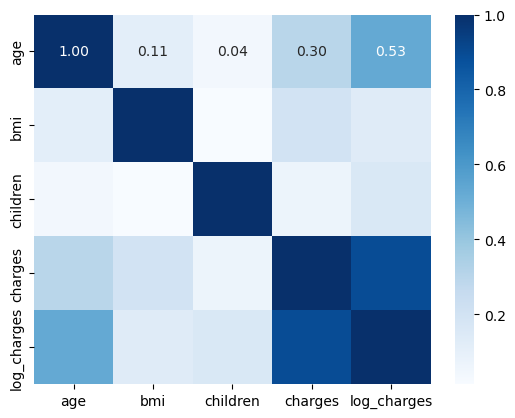

<Figure size 1000x800 with 0 Axes>

In [52]:
sns.heatmap(correlations, cmap='Blues', annot=True, fmt='.2f')
plt.figure(figsize=(10,8))
plt.tight_layout()  
plt.show()

Using `pairplot`:

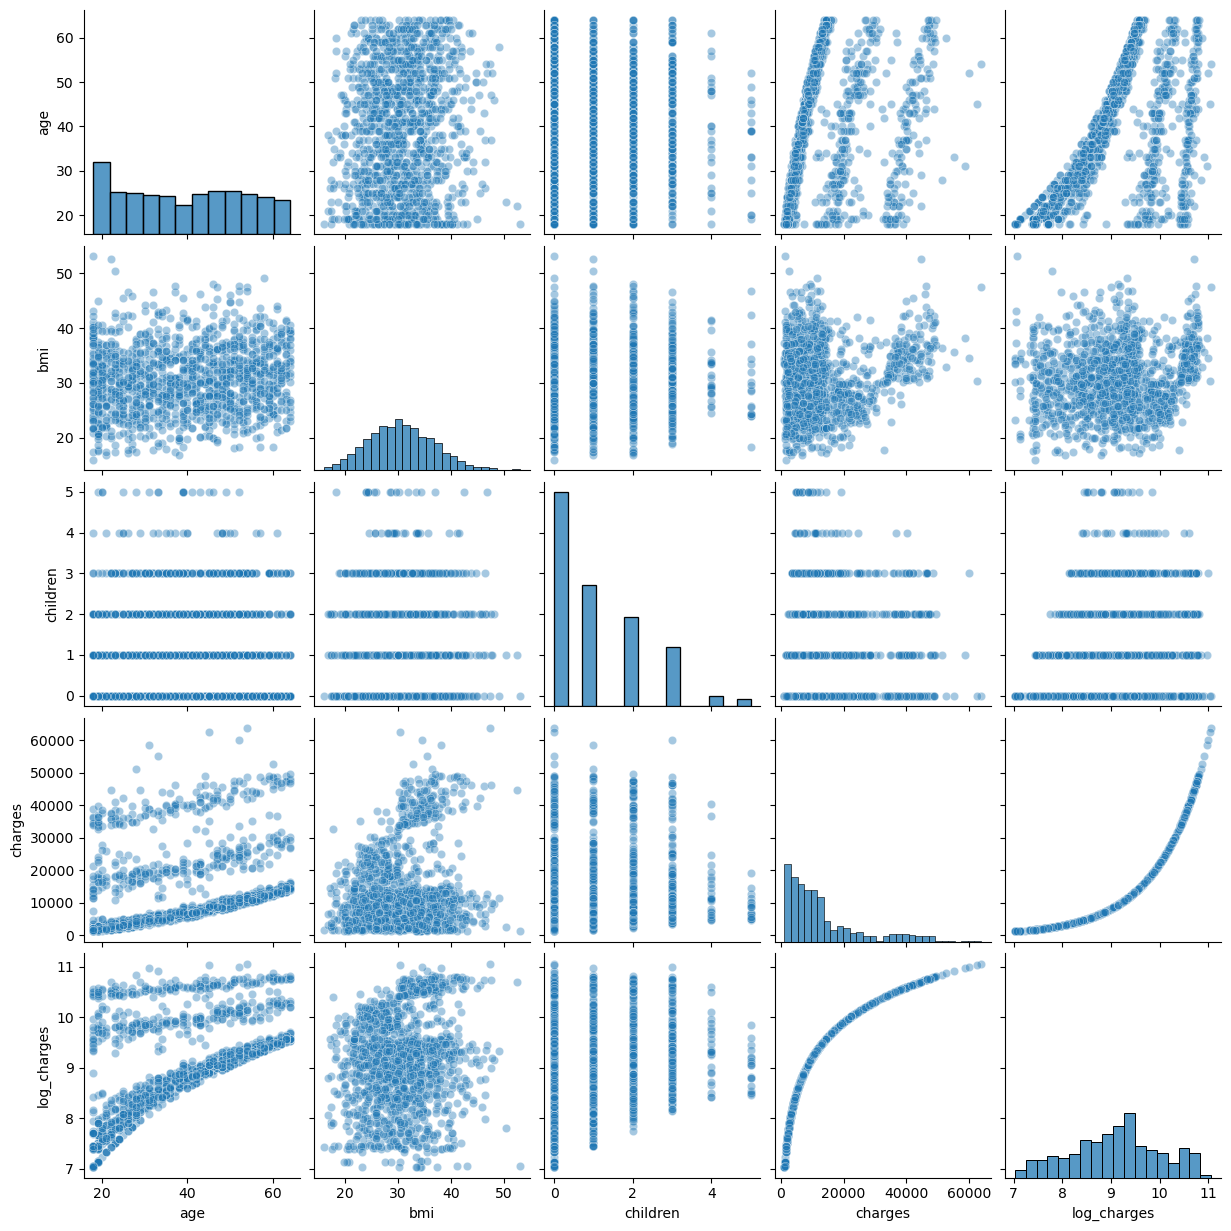

In [53]:
Insurance_numeric = Insurance.select_dtypes(np.number)
sns.pairplot(Insurance_numeric, kind = 'scatter', plot_kws={'alpha': 0.4})

Children vs log_charges, and Children vs charges shows long bands visually. This is because children have discrete variables. There's 3 distinct band between age and charges.

### looking at our Categorical Variables

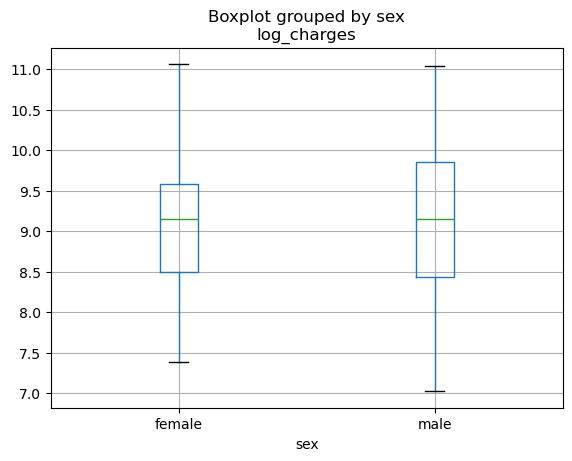

In [54]:
Insurance.boxplot(column=['log_charges'], by='sex')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

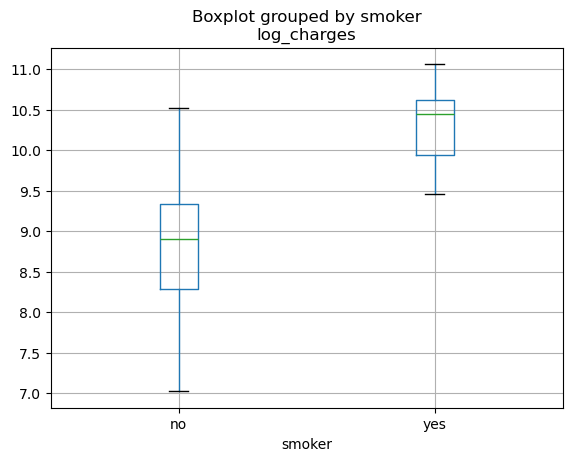

In [55]:
Insurance.boxplot(column=["log_charges"], by='smoker')
plt.show

the yes-smoker box has a higher values for median, lower quartile, and upper-quartile cost-wese. So it might be useful to our model

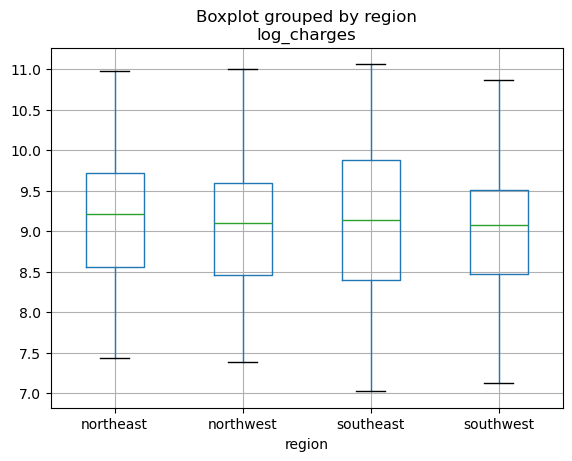

In [56]:
Insurance.boxplot(column=['log_charges'], by='region')
plt.show()

## Spliting our Data

In [60]:
Insurance['is_smoker'] = (Insurance['smoker']=="yes")
#convert yes to numerical 1 and 0 and add column to our data

X = Insurance[['age', 'bmi', 'is_smoker']]
y = Insurance['log_charges']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)

## Training our model

In [62]:
from sklearn.linear_model import LinearRegression
Insurance_model = LinearRegression()
Insurance_model.fit(X_train, y_train)
Insurance_model.coef_

array([0.03525471, 0.01083897, 1.547207  ])

In [67]:
Insurrance_coefficient = pd.DataFrame(Insurance_model.coef_, X.columns, columns=['Coef'])
print(Insurrance_coefficient)

               Coef
age        0.035255
bmi        0.010839
is_smoker  1.547207


This coefficients signifies the variables that has influence on our model

### Predicting our values with our training sets

In [68]:
y_pred = Insurance_model.predict(X_train)

In [69]:
print(y_pred)

[ 8.17257058  8.34453469  9.29835904 ...  9.38770597 10.43762797
  9.33315597]


So, remember we have to undo our log transformation.

## Model Evaluatuation for our training set

#### Mean Squared Error

In [70]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.21520412786852908

In [71]:
train_mse_orig_scale = np.exp2(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

1.1608681547615856

#### R2 Score

In [72]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7433336007728251

The R2 score reveals that our predictors influences the variance of the yearly amount by roughly 75%

### Residuals
Basically how different predicted values are from actual values

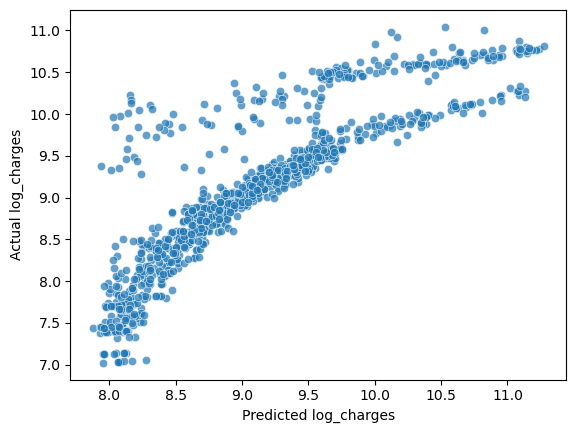

In [84]:
plot_df = pd.DataFrame({'predictions': y_pred,
                        'actual': y_train,
                        'is_smoker': X_train['is_smoker'],
                        'age': X_train['age'],
                        'bmi': X_train['bmi'],
                        'residuals': y_train - y_pred,})

sns.scatterplot(x = 'predictions', y = 'actual', data = plot_df, alpha=0.7)
plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

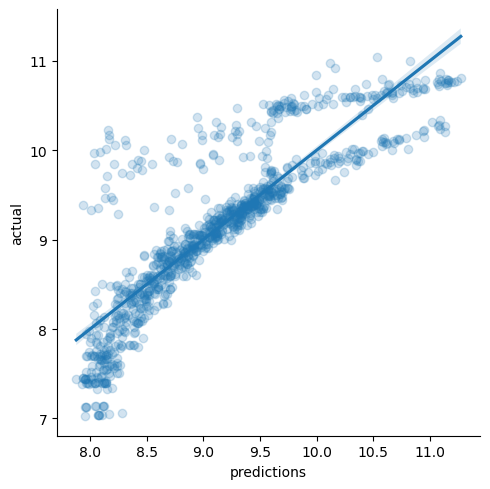

In [87]:
sns.lmplot(x = "predictions", y = "actual", data = plot_df, scatter_kws={'alpha':0.2})

Let's investigate the residual to see what might be the problem

<Axes: xlabel='predictions', ylabel='residuals'>

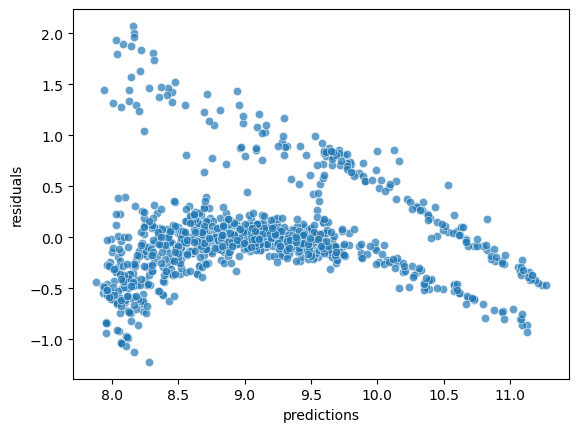

In [86]:
sns.scatterplot(x = 'predictions', y = 'residuals', data = plot_df, alpha=0.7)

the residuals is not random. it means there's something wrong

## Evaluation using our test set

In [88]:
test_pred = Insurance_model.predict(X_test)
mean_squared_error(y_test, test_pred)

0.21761069768338046

converting to our original form

In [91]:
np.exp2(mean_squared_error(y_test, test_pred))

1.1628062231551979

The mean squared error are quite small, but the residuals are telling a different story

let's check to see what could possibly be wrong, by revisiting out plot

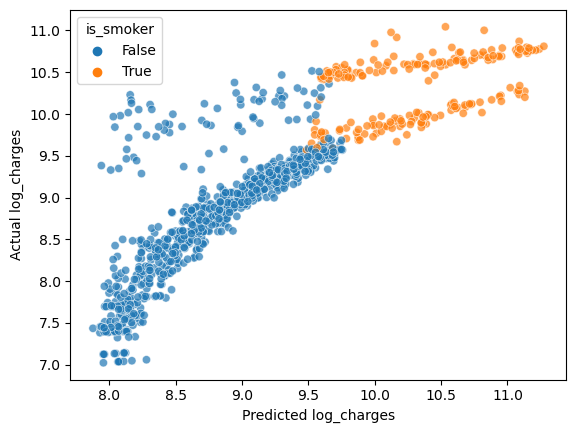

In [96]:
plot_df = pd.DataFrame({'predictions': y_pred,
                        'actual': y_train,
                        'is_smoker': X_train['is_smoker'],
                        'age': X_train['age'],
                        'bmi': X_train['bmi'],
                        'residuals': y_train - y_pred,})

sns.scatterplot(x = 'predictions', y = 'actual', data = plot_df, alpha=0.7, hue='is_smoker')
plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

so, we see the smoker and the non smoker are seperated